# AdaBoost介绍

Adaboost算法中有两种权重，一种是数据的权重，另一种是弱分类器的权重。其中，数据的权重主要用于弱分类器寻找其分类误差最小的决策点，找到之后用这个最小误差计算出该弱分类器的权重（发言权），分类器权重越大说明该弱分类器在最终决策时拥有更大的发言权。
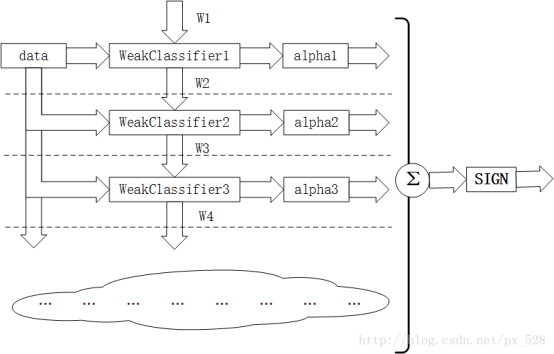

基于当前的数据权重Wi对数据集data训练出一个基学习器，得到此基学习器的权重αi，当进行权重更新时，会依据公式增加错分样本的权重值，同时减小正确分类样本的权重值，并对新权重进行归一化。最后将所有T个基学习器与自己的权重相乘在求和,最后对结果使用sign函数。即：
H（x）=sign()

Sign（·）在·<0,=0,>0时分别取值为-1,0,1

AdaBoost算法伪代码：

输入：训练集D={（x1,y1）,（x2,y2）,.......,(xm,ym)};
     基学习算法£；
     训练轮数T；
      
过程：

1.W1（x）=1/m             初始化样本权值分布

2.For t=1,2,.....,T do
3.    ht=£(D,Wt) 基于样本权值Wt从数据集D中训练出分类器ht
4.    Et=Wt*I(hty)     估计ht的误差
5.    If Et>0.5 then break  
6.    αt= 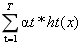     确定分类器ht的权重
7.    Wt+1= 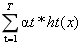 更新样本权重，Zt是规范化因子

8.End for

输出：H（x）=sign(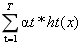)

In [30]:
import numpy as np
import pandas as pd
import math
from sklearn.datasets import load_iris
from sklearn.model_selection  import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
    

In [31]:
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    # print(data)
    return data[:,:2], data[:,-1]

In [32]:

X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

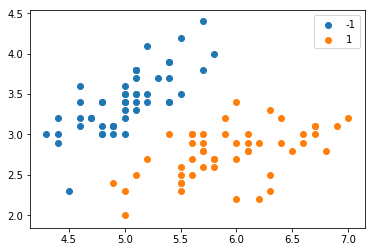

In [33]:
plt.scatter(X[:50,0],X[:50,1], label='-1')
plt.scatter(X[50:,0],X[50:,1], label='1')
plt.legend()

In [52]:
class adaBoostModel():
    def __init__(self,classifierNums=10,baseLearningAlgorithm='simpleClassify'):
        self.classifierNums=classifierNums  #弱分类器数量
        self.baseLearningAlgorithm=baseLearningAlgorithm  #基学习算法
        self.weakClassifierArr=[]
        self.alphaArr=[]


    def train(self,Xtrain,ytrain):
        m,n=Xtrain.shape
        ytrain=np.mat(ytrain)
        D=np.ones((m,1))/m

        if self.baseLearningAlgorithm == 'simpleClassify':
            sc = simpleClassifyModel()
            for iter in range(self.classifierNums):
                sc.train(Xtrain,ytrain,D)
                featIndex=sc.bestStump['featIndex']
                thresh=sc.bestStump['thresh']
                ineq=sc.bestStump['inequal']
                error=sc.bestStump['error']
                if error>0.5:
                    break
                self.weakClassifierArr.append((featIndex,thresh,ineq))  
                alpha=0.5*(math.log((1-error)/error))
                self.alphaArr.append(alpha)
                expon=np.multiply(ytrain.T,sc.bestStump['predictVals'])
                D=np.multiply(D,np.exp(-alpha*expon))
                Zt=np.sum(D)
                D=D/Zt

        print("adaBoost train complete!")


    def predict(self,Xtest):
        m=Xtest.shape[0]
        H=np.zeros((m,1))
        if self.baseLearningAlgorithm == 'simpleClassify':
            predictSC=simpleClassifyModel()
            for i in range(len(self.weakClassifierArr)):
                predictVals=predictSC.predict(Xtest,self.weakClassifierArr[i][0],self.weakClassifierArr[i][1],self.weakClassifierArr[i][2])
                H+=self.alphaArr[i]*predictVals

        return np.sign(H)


    def score(self,Xtest,ytest):
        m=Xtest.shape[0]
        ytest=np.mat(ytest).T
        predictVals=self.predict(Xtest)
        accuracy=(predictVals==ytest)
        accuracy=np.sum(accuracy)/m
        print("accuracy is ",accuracy*100)



class simpleClassifyModel():
    def __init__(self):
        self.bestStump={}


    def train(self,Xtrain,ytrain,D):
        m,n=Xtrain.shape
        ytrain=np.mat(ytrain)
        numSteps=10
        minError=math.inf
        bestFeatIndex=-1
        bestThresh=math.inf
        bestInEqual=None
        bestPredictVals=None
        for i in range(n):
            rangeMin=np.min(Xtrain[:,i])
            rangeMax=np.max(Xtrain[:,i])
            stepSize=(rangeMax-rangeMin)/numSteps
            for j in range(-1,numSteps+1):
                for inequal in ['lt','gt']:
                    threshVal=rangeMin+j*stepSize
                    predictVals=self.predict(Xtrain,i,threshVal,inequal)
                    errArr=1-(predictVals==ytrain.T)    #预测正确为0，预测错误为1
                    weightedError=D.T.dot(errArr)
                    if weightedError<minError:
                        minError=weightedError
                        bestFeatIndex=i
                        bestThresh=threshVal
                        bestInEqual=inequal
                        bestPredictVals=predictVals.copy()

        self.bestStump['featIndex']=bestFeatIndex
        self.bestStump['thresh']=bestThresh
        self.bestStump['inequal']=bestInEqual
        self.bestStump['error']=minError
        self.bestStump['predictVals']=bestPredictVals
        print("fit complete!")


    def predict(self,X,featIndex,threshVal,inequal):
        m=X.shape[0]
        predictVals=np.ones((m,1))
        if inequal=='lt':
            predictVals[X[:,featIndex]<=threshVal]=-1
        else:
            predictVals[X[:,featIndex]>threshVal]=-1
        return predictVals
    
    
    
    def score(self,X,y):
        m=X.shape[0]
        predictVals=self.predict(X,self.bestStump['featIndex'],self.bestStump['thresh'],self.bestStump['inequal'])
        y = np.mat(y).T
        accuracy = (predictVals == y)
        accuracy = np.sum(accuracy) / m
        print("accuracy is ", accuracy*100)


In [53]:
#未使用adaBoost前的训练和测试正确率
mySC=simpleClassifyModel()
m=X_train.shape[0]
D=np.ones((m,1))  #让所有样本的权重都为1，即等于没设置权重
mySC.train(X_train,y_train,D)
print(mySC.bestStump['featIndex'])
print(mySC.bestStump['thresh'])
print("without adaBoost training accuracy:")
mySC.score(X_train,y_train)

print("without adaBoost testing accuracy:")
mySC.score(X_test,y_test)

fit complete!
0
5.38
without adaBoost training accuracy:
accuracy is  87.5
without adaBoost testing accuracy:
accuracy is  75.0


In [54]:
#使用adaBoost后的训练和测试正确率
myAda=adaBoostModel()
myAda.train(X_train,y_train)
print("training:")
myAda.score(X_train,y_train)
print("testing:")
myAda.score(X_test,y_test)

fit complete!
fit complete!
fit complete!
fit complete!
fit complete!
fit complete!
fit complete!
fit complete!
fit complete!
fit complete!
adaBoost train complete!
training:
accuracy is  100.0
testing:
accuracy is  100.0
